# 空調熱源機器の性能曲線のグラフ作成プログラム

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pprint as pp

# グラフ文字化け対策
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 0.5

%matplotlib inline

## 0. 熱源機種名称の指定（入力）

In [2]:
typeName = "ウォータチリングユニット(空冷式モジュール形氷蓄熱用)"


## 1. データベースファイルの読み込み
- 性能曲線の係数等を格納している HeatSourcePerformance.json の読み込み

In [3]:
# データベースjsonの読み込み
with open('./builelib/database/HeatSourcePerformance.json', 'r') as f:
    db = json.load(f)

## 2.グラフ描画

In [55]:
# グラフの描画範囲
dT = 2.5
xCapacity_C = np.arange(-5,45+dT,dT)   # 能力比 冷房
xInput_C    = np.arange(-5,45+dT,dT)   # 入力比 冷房
xLoad_C     = np.arange(0,1+0.1,0.1)   # 部分負荷率 冷房
xSupply_C   = np.arange(-5,20+dT,dT)   # 送水温度 冷房
xCapacity_H = np.arange(-20,20+dT,dT)  # 能力比 暖房
xInput_H    = np.arange(-20,20+dT,dT)  # 入力比 暖房
xLoad_H     = np.arange(0,1+0.1,0.1)   # 部分負荷率 暖房
xSupply_H   = np.arange(30,60+dT,dT)   # 送水温度 暖房

In [56]:
def calcQuarticCurve(dataSet, T):
    """
    性能曲線の4次式計算（冷却水温度による変化がない場合）
    """

    # 条件に応じて複数の係数がある場合、Tの値に基づき、該当する係数を選ぶ。
    paraSet = []
    for i in range(0, len(dataSet)):
        
        if i == 0 and T < dataSet[0]["下限"]:  # 全ての下限を下回っている場合
            paraSet = dataSet[0]
            break
        elif dataSet[i]["下限"] <= T and T < dataSet[i]["上限"]:  # 下限と上限の間にある場合
            paraSet = dataSet[i]
            break
        elif i == len(dataSet)-1 and dataSet[-1]["上限"] <= T:  # 全ての上限を上回っている場合
            paraSet = dataSet[-1]
            break

    # 上限と下限でリミットをかける。
    if T < paraSet["下限"]:
        T = paraSet["下限"]
    elif paraSet["上限"] < T:
        T = paraSet["上限"]

    # ４次式
    y =   float(paraSet["係数"]["a4"]) * T ** 4 \
        + float(paraSet["係数"]["a3"]) * T ** 3 \
        + float(paraSet["係数"]["a2"]) * T ** 2 \
        + float(paraSet["係数"]["a1"]) * T \
        + float(paraSet["係数"]["a0"])

    return y

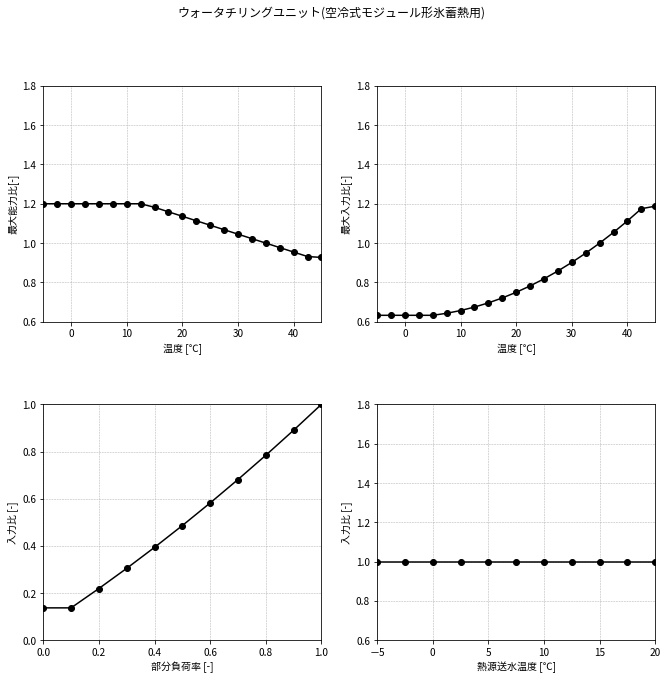

In [61]:
## 冷房の特性

if "冷房時の特性" in db[typeName]:

    ## 能力比
    dataSet = sorted(db[typeName]["冷房時の特性"]["能力比"], key=lambda x:x['下限'], reverse=False) # 下限値の小さい順に並び替え

    yCapacity_C = list()
    for T in xCapacity_C:
        yCapacity_C.append(calcQuarticCurve(dataSet,T))

    ## 入力比
    dataSet = sorted(db[typeName]["冷房時の特性"]["入力比"], key=lambda x:x['下限'], reverse=False) # 下限値の小さい順に並び替え

    yInput_C = list()
    for T in xInput_C:
        yInput_C.append(calcQuarticCurve(dataSet,T))

    ## 部分負荷特性
    dataSet = sorted(db[typeName]["冷房時の特性"]["部分負荷特性"], key=lambda x:x['下限'], reverse=False) # 下限値の小さい順に並び替え

    yLoad_C = list()
    for T in xLoad_C:
        yLoad_C.append(calcQuarticCurve(dataSet,T))

    ## 送水温度特性
    dataSet = sorted(db[typeName]["冷房時の特性"]["送水温度特性"], key=lambda x:x['下限'], reverse=False) # 下限値の小さい順に並び替え

    ySupply_C = list()
    for T in xSupply_C:
        ySupply_C.append(calcQuarticCurve(dataSet,T))


fig1 = plt.figure(figsize=(10,10))
fig1.suptitle(typeName)
fig1.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.87, wspace=0.20, hspace=0.35)

ax1 = fig1.add_subplot(2,2,1)
ax1.plot(xCapacity_C, yCapacity_C, 'k')
ax1.plot(xCapacity_C, yCapacity_C, 'ko')
ax1.set_xlim([-5,45])
ax1.set_ylim([0.6,1.8])
ax1.set_xlabel("温度 [℃]")
ax1.set_ylabel("最大能力比[-]")
ax1.grid()

ax2 = fig1.add_subplot(2,2,2)
ax2.plot(xInput_C, yInput_C, 'k')
ax2.plot(xInput_C, yInput_C, 'ko')
ax2.set_xlim([-5,45])
ax2.set_ylim([0.6,1.8])
ax2.set_xlabel("温度 [℃]")
ax2.set_ylabel("最大入力比[-]")
ax2.grid()

ax3 = fig1.add_subplot(2,2,3)
ax3.plot(xLoad_C, yLoad_C, 'k')
ax3.plot(xLoad_C, yLoad_C, 'ko')
ax3.set_xlim([0,1.0])
ax3.set_ylim([0,1.0])
ax3.set_xlabel("部分負荷率 [-]")
ax3.set_ylabel("入力比 [-]")
ax3.grid()

ax4 = fig1.add_subplot(2,2,4)
ax4.plot(xSupply_C, ySupply_C, 'k')
ax4.plot(xSupply_C, ySupply_C, 'ko')
ax4.set_xlim([-5,20])
ax4.set_ylim([0.6,1.8])
ax4.set_xlabel("熱源送水温度 [℃]")
ax4.set_ylabel("入力比 [-]")
ax4.grid()

plt.show()
